In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
from clickhouse_driver import Client

In [2]:
# имя контейнера
CONTAINER_NAME = 'clickhouse-server'

In [6]:
# имя базы данных
DATABASE_NAME = 'testcase_database' 

In [9]:
#запуск Docker контейнера ClickHouse
subprocess.run(['docker', 'start', CONTAINER_NAME])

CompletedProcess(args=['docker', 'start', 'inspiring_wilbur'], returncode=0)

In [3]:
# прописываем параметры клиента для запросов
client = Client(host='localhost', port=9000, user='default', password='', database=DATABASE_NAME)

In [13]:
# проверка что контейнер запущен, запрашиваем в докере список запущенных контейнеров и ищем среди них имя нашего
result = subprocess.run(['docker', 'ps', '--format', '{{.Names}}'], capture_output=True, text=True)

if result.returncode != 0:
    print("Ошибка при выполнении команды:")
    print(result.stderr)
else:
    container_names = result.stdout.strip().split('\n')
    if CONTAINER_NAME in container_names:
        print(f"Контейнер {CONTAINER_NAME} запущен.")
    else:
        print(f"Контейнер {CONTAINER_NAME} не запущен. Проверьте настройки!")

Контейнер clickhouse-server не запущен. Проверьте настройки!


In [5]:
#тестовый запрос
query = 'SELECT 1'
try:
    result = client.execute(query)
    if result:
        print('Тестовый запрос к базе данных прошел успешно')
    else:
        print('Запрос выполнен, но вернул пустой результат')
except Exception as e:
    print(f'Произошла ошибка при выполнении запроса: {e}')

Тестовый запрос к базе данных прошел успешно


In [8]:
# запрос к базе данных
query = """
    SELECT
        UserID,
        FirstName,
        LastName,
        BirthDate,
        LastSeenTime,
        Contacts,
        City,
        FriendsCount
    FROM 
        Users AS U
    LEFT JOIN 
        FirstNames AS FN ON U.FirstNameID=FN.FirstNameID
    LEFT JOIN 
        LastNames AS LN ON U.LastNameID=LN.LastNameID
    LEFT JOIN 
        Cities AS C ON U.CityID=C.CityID
"""

In [9]:
# выполнение запроса 
data = client.execute(query)

In [10]:
# получение списка названий столбцов
columns_query = 'DESCRIBE TABLE Users'
columns = client.execute(columns_query)
column_names = [col[0] for col in columns]

# преобразование в DataFrame и добавление названий столбцов
df = pd.DataFrame(data, columns=column_names)

In [17]:
# проверка как выгрузился датафрейм 
df.head()

,UserID,FirstNameID,LastNameID,BirthDate,LastSeenTime,Contacts,CityID,FriendsCount
0,48,Misha,Melnikov,1970-01-01,1970-01-01 00:00:00,nan,NaN,0
1,1018,Yarik,Burim,1970-01-01,2021-02-19 04:15:36,nan,Saint Petersburg,0
2,1185,Alexey,Mogilov,1970-01-01,1970-01-01 00:00:00,nan,NaN,188
3,1721,Maxim,Lotsoka,1970-01-01,1970-01-01 00:00:00,nan,NaN,748
4,2136,Yaroslav,Tekhnik,1970-01-01,2022-09-29 19:13:26,nan,Ryazan,70


In [17]:
# останавливаем докер, чтобы не нагружать ресурсы системы
subprocess.run(['docker', 'stop', CONTAINER_NAME], capture_output=True, text=True)
# обработка возможных ошибок остановки
if result.returncode != 0:
    print("Ошибка при выполнении команды:")
    print(result.stderr)
else:
    print(f"Контейнер {CONTAINER_NAME} остановлен.")

CompletedProcess(args=['docker', 'stop', 'clickhouse-server'], returncode=0)

In [18]:
# переименование столбцов
df.rename(columns={'FirstNameID': 'FirstName', 'LastNameID': 'LastName', 'CityID': 'CityName'}, inplace=True)

In [19]:
# проверка на дубликаты
df.duplicated().sum()

0

In [20]:
# общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858239 entries, 0 to 858238
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   UserID        858239 non-null  int64         
 1   FirstName     858238 non-null  object        
 2   LastName      857164 non-null  object        
 3   BirthDate     858239 non-null  datetime64[ns]
 4   LastSeenTime  858239 non-null  datetime64[ns]
 5   Contacts      858239 non-null  object        
 6   CityName      594076 non-null  object        
 7   FriendsCount  858239 non-null  Int32         
dtypes: Int32(1), datetime64[ns](2), int64(1), object(4)
memory usage: 49.9+ MB


**Найти Топ - 5 самых популярных имен**

In [17]:
# выводим топ-5
df['FirstName'].value_counts().head()

FirstName
Alexander    57618
Sergey       45720
Andrey       35356
Alexey       33493
Dmitry       29055
Name: count, dtype: int64

In [18]:
# готовим переменные для построения графика
top_5_names = df['FirstName'].value_counts().head()
top_5_names_df = top_5_names.reset_index()
top_5_names_df.columns = ['FirstName', 'Count']

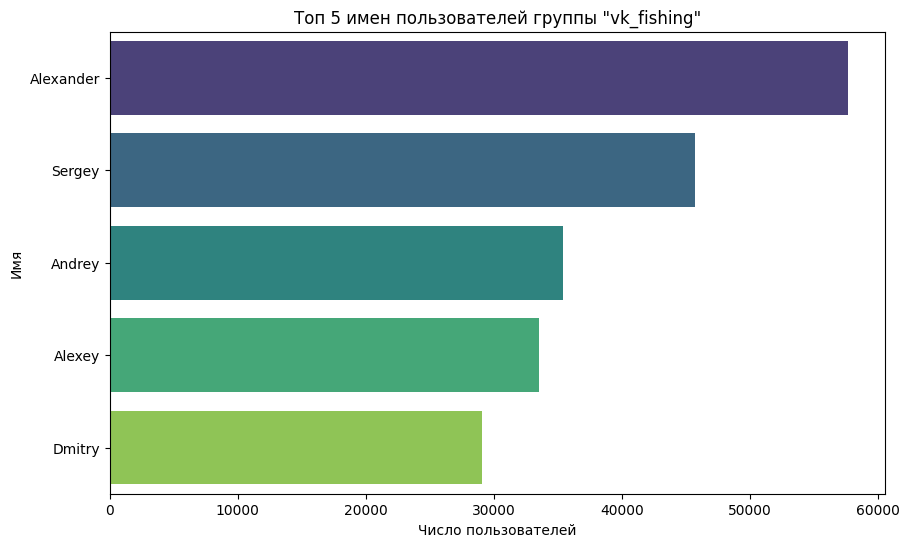

In [19]:
# строим график
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='FirstName', hue='FirstName', data=top_5_names_df, palette='viridis', dodge=False)
plt.xlabel('Число пользователей')
plt.ylabel('Имя')
plt.title('Топ 5 имен пользователей группы "vk_fishing"')
plt.legend([],[], frameon=False)
plt.show()

Наиболее часто встречаемым именем среди пользователей группы vk_fishing, является Александр. Далее, по нисходящей идут - Сергей, Андрей, Алексей, Дмитрий.

**Построить диаграмму рассеяния, зависимость количества друзей от возраста**

In [21]:
df['FriendsCount'].value_counts(dropna=False)

FriendsCount
0       235892
1         9919
2         7075
3         5666
4         5010
         ...  
5202         1
2342         1
4449         1
5767         1
8184         1
Name: count, Length: 6372, dtype: Int64

Нулевые значения лидируют, при этом с большим отрывом, это будет искажать наш график, отфильтруем данные и посмотрим на статистику без нулевых значений.

In [22]:
# фильтруем по значениям больше нуля и смотрим по ним статистику
df[df['FriendsCount'] > 0]['FriendsCount'].describe()

count      622347.0
mean      247.61682
std      584.281111
min             1.0
25%            54.0
50%           134.0
75%           258.0
max         10000.0
Name: FriendsCount, dtype: Float64

Мы потеряли 235 892 значения, с такой фильтрацией. В оставшихся данных медианное количество друзей равно 134-м, при среднем значении в 247 друзей. Это указывает на наличие выбросов. Половина всех данных находитс в промежутке от 54 до 258 друзей, но чтобы сильно не искажать данные отбросим 2 процента из наиболее больших значений. 

In [23]:
# выясняем граничное значение для фильтрации
q = df[df['FriendsCount'] > 0]['FriendsCount'].quantile(0.98)
q

1301.0

In [24]:
# фильтруем датафрейм 
df_filtered = df.query('FriendsCount > 0 & FriendsCount < @q')

Таким образом мы убрали все записи где количество друзей превышало 1300. Перейдем к данным о возрасте.

In [25]:
df_filtered['BirthDate'].value_counts()

BirthDate
1970-01-01    299204
1901-01-01       185
2000-01-01       173
2004-01-02       140
1990-01-01       137
               ...  
1949-12-21         1
2008-11-30         1
1917-10-29         1
1944-10-23         1
1962-12-09         1
Name: count, Length: 24934, dtype: int64

Дата 1 января 1970 года была выбрана как заглушка для отсутствующих или ошибочных данных при выгрузке. Можем отфильтровать их. Высчитаем возраст и отфильтруем нереальные значения.

In [45]:
# копируем датафрейм
df_filtered_bdates = df_filtered[df_filtered['BirthDate'] != '1970-01-01'].copy()
# текущая дата
actual_date = pd.to_datetime('2024-05-09', format='%Y-%m-%d')
# ыычисляем возраст
df_filtered_bdates['Age'] = df_filtered_bdates['BirthDate'].apply(lambda x: (actual_date - x).days // 365)

In [46]:
# отфильтровываем, нижняя грань - минимальный возраст использования vk, верхний - предположение на основе здравого смысла
df_filtered_bdates = df_filtered_bdates.query('Age < 90 & Age > 13')

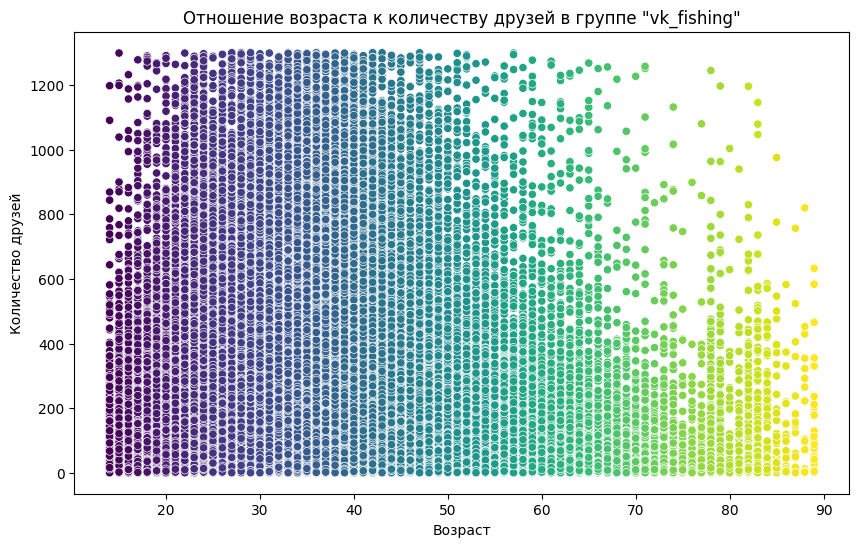

In [47]:
# Построение графика с использованием seaborn

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='FriendsCount', hue='Age', data=df_filtered_bdates, palette='viridis')
plt.xlabel('Возраст')
plt.ylabel('Количество друзей')
plt.title('Отношение возраста к количеству друзей в группе "vk_fishing"')
plt.legend([],[], frameon=False)
plt.show()

Пик количества друзей приходится на возраст пользователей примерно от 20 до 45 лет.

**Выдать топ-3 города, в которых среднее кол-во друзей участников группы самое наибольшее**

Возьмем для работы сразу отфильтрованный ранее датафрейм, чтобы избежать значительных искажений в данных.

In [49]:
# получаем топ городов по колиечтву участников
df_filtered['CityName'].value_counts(dropna=False)

CityName
Moscow                26194
Saint Petersburg      15140
Kyiv                  11370
Kharkiv                5774
Odessa                 4869
                      ...  
Butyrki                   1
Balkovtsy                 1
Turkushi                  1
Zastenki                  1
Nizhnyaya Rozhanka        1
Name: count, Length: 16163, dtype: int64

Как мы видим в данных лидирует пустое значение, то есть там где город не был заполнен или был заполнен некорректными значениями. Отфильтруем эти данные. 

In [48]:
# фильтрация пустых значений
df_filtered = df_filtered[df_filtered['CityName'] != '']

In [54]:
# сгруппируем по городам и посмотрим среднее количество друзей и количество участников из этого города в наших данных
df_filtered.groupby('CityName')['FriendsCount'].agg({'count','mean'}).reset_index().sort_values(by='count', ascending=False)

,CityName,count,mean
8039,Moscow,26194,178.791021
11198,Saint Petersburg,15140,209.359511
6532,Kyiv,11370,176.635356
4997,Kharkiv,5774,167.315899
9223,Odessa,4869,167.448141
...,...,...,...
7280,Makkaveevo,1,2.000000
7283,Makovichi,1,205.000000
7288,Makwa,1,1.000000
7289,Malabo,1,78.000000


После группировки и предобработки, мы видим что нам требуется отбросить значения в котороых количество участников из этого города недостаточно чтобы можно было работать с этими данными. При условии, что после очистки от выбросов в значениях количества друзей, максимальное число участников из одного города это 26 тысяч, а первую пятёрку замыкает значение в 4869 участников, мы можем взять 1000 участников как основу для фильтрации данных.  

In [114]:
# получаем количество участников для каждого города, после выбираем названия только тех городов, 
# для которых это количество больше или равно 1000 и фильтруем датафрейм, оставляя только эти города
city_counts = df_filtered['CityName'].value_counts()
filtered_cities = city_counts[city_counts >= 1000].index
df_filtered_cities = df_filtered[df_filtered['CityName'].isin(filtered_cities)]
len(df_filtered_cities)

После фильтрации у нас осталось 221 821 запись в нашем датафрейме. Посмотрим на топ-10 городов по численности и среднему значению количества друзей. 

In [120]:
# групируем по имени города, смотрим число участников, среднее и медиану, сортируем сначала по количеству участников, потом по среднему и выводим топ-10
df_filtered_cities.groupby('CityName')['FriendsCount'].agg({'count','mean','median'}).reset_index().sort_values(by=['count','mean'], ascending=False).head(10)

,CityName,median,count,mean
42,Moscow,119.0,26194,178.791021
61,Saint Petersburg,153.0,15140,209.359511
34,Kyiv,134.0,11370,176.635356
26,Kharkiv,128.0,5774,167.315899
47,Odessa,127.0,4869,167.448141
24,Kazan,176.0,4804,233.143422
40,Minsk,131.0,4628,173.200951
1,Almaty,100.0,4342,138.895901
54,Perm,199.0,4230,253.708983
30,Krasnodar,120.0,3995,164.741427


В лидерах по среднему количеству друзей у участников - Пермь, Казань и Санкт-Петербург. Однако, учитывая неравномерность данных (количество участников из этих городов), в первую тройку нам следует взять всё-таки Москву, Санкт-Петербург и Киев. Так как мы видим довольно большую разницу между медианой и средним по всем значениям, мы выборочно посмотрим три города с самыми большим средним количеством друзей на экстремальные выбросы

In [117]:
df_filtered_cities[df_filtered_cities['CityName'] == 'Saint Petersburg'].sort_values(by='FriendsCount', ascending=False).head(10)

,UserID,FirstName,LastName,LastSeenTime,Contacts,CityName,FriendsCount
209806,44837081,Konstantin,Salamatov,2024-05-27 05:11:47,nan,Saint Petersburg,1296
151299,253454267,Kristina,Kolganova,2024-05-27 14:32:12,nan,Saint Petersburg,1295
248553,287164143,Vyacheslav,Shadrenkov,2024-05-27 13:42:05,nan,Saint Petersburg,1295
171811,262996442,Maxim,Ivanov,2024-05-27 15:49:42,nan,Saint Petersburg,1294
755665,581716173,Zhiromir,Dvornik,2024-03-06 12:17:47,nan,Saint Petersburg,1286
821290,718694850,Karim,Sharipov,2022-08-23 03:59:25,+79242190777,Saint Petersburg,1284
612268,447816644,Vova,Afonin,2024-05-27 07:33:40,nan,Saint Petersburg,1283
160523,31073330,Konstantin,Donya,2024-05-27 16:17:24,nan,Saint Petersburg,1279
207338,43239226,Alexey,Polikkhanikov,2024-05-27 16:32:41,112,Saint Petersburg,1275
278387,64515263,Andrey,Kotugin,2024-05-27 11:25:33,nan,Saint Petersburg,1265


In [118]:
df_filtered_cities[df_filtered_cities['CityName'] == 'Kazan'].sort_values(by='FriendsCount', ascending=False).head(10)

,UserID,FirstName,LastName,LastSeenTime,Contacts,CityName,FriendsCount
93736,17609587,Roman,Afanasyev,2024-05-27 04:38:28,nan,Kazan,1288
222013,48198420,Eduard,Lyalin,2024-05-27 13:02:45,nan,Kazan,1286
854839,209167160,Igor,Dautov,2024-03-11 19:49:14,nan,Kazan,1278
425284,113002890,Artyom,Ivanov,2024-05-27 13:33:57,nan,Kazan,1260
617687,154309792,Robert,Sadykov,2024-05-01 03:38:10,нет,Kazan,1251
277472,64101811,Ruslan,Irekowich,2024-05-27 10:35:02,nan,Kazan,1249
344027,84748259,Pasha,Belyaev,2024-05-27 16:31:49,nan,Kazan,1245
369640,90909633,Dmitry,Zhizhikin,2024-05-27 11:38:08,nan,Kazan,1235
453370,121365643,Ildar,Salimov,2024-05-27 08:14:09,nan,Kazan,1235
471241,128351242,Marsel,Siraziev,2024-05-27 13:37:48,nan,Kazan,1233


In [119]:
df_filtered_cities[df_filtered_cities['CityName'] == 'Perm'].sort_values(by='FriendsCount', ascending=False).head(10)

,UserID,FirstName,LastName,LastSeenTime,Contacts,CityName,FriendsCount
136659,248610329,Vladislav,Avkhadeev,2024-05-27 14:49:12,nan,Perm,1282
18803,4330265,Irina,Balezina,2024-05-26 19:32:38,nan,Perm,1271
757262,585548023,Alexey,Nikolaev,2024-05-26 20:11:49,+79068776141,Perm,1268
373901,93890161,Oleg,Agafonov,2024-05-27 14:14:21,nan,Perm,1265
307418,70603053,Dima,Bely,2024-05-27 14:41:22,nan,Perm,1254
752558,183872570,Dmitry,Krivoschekov,2024-05-27 15:59:46,nan,Perm,1245
453078,121166443,Vladislav,Vladimirov,2024-05-27 16:33:23,nan,Perm,1236
40282,9388816,Alexey,Vyatkin,2024-05-27 13:08:59,nan,Perm,1233
109294,20449809,Alexander,Koskov,2024-05-27 16:15:08,nan,Perm,1231
474340,131739292,Sergey,Popov,2024-05-27 16:36:13,nan,Perm,1229


Для всех трех городов(Пермь, Санкт-Петербург и Казань), значения более 1200 друзей не выглядят выбросами. Они имеют как минимум по 10 выглядящих реальными пользователей с такими данными. Так что мы с некой долей вероятности можем делать выводы на этих данных. Изобразим наш топ на графике

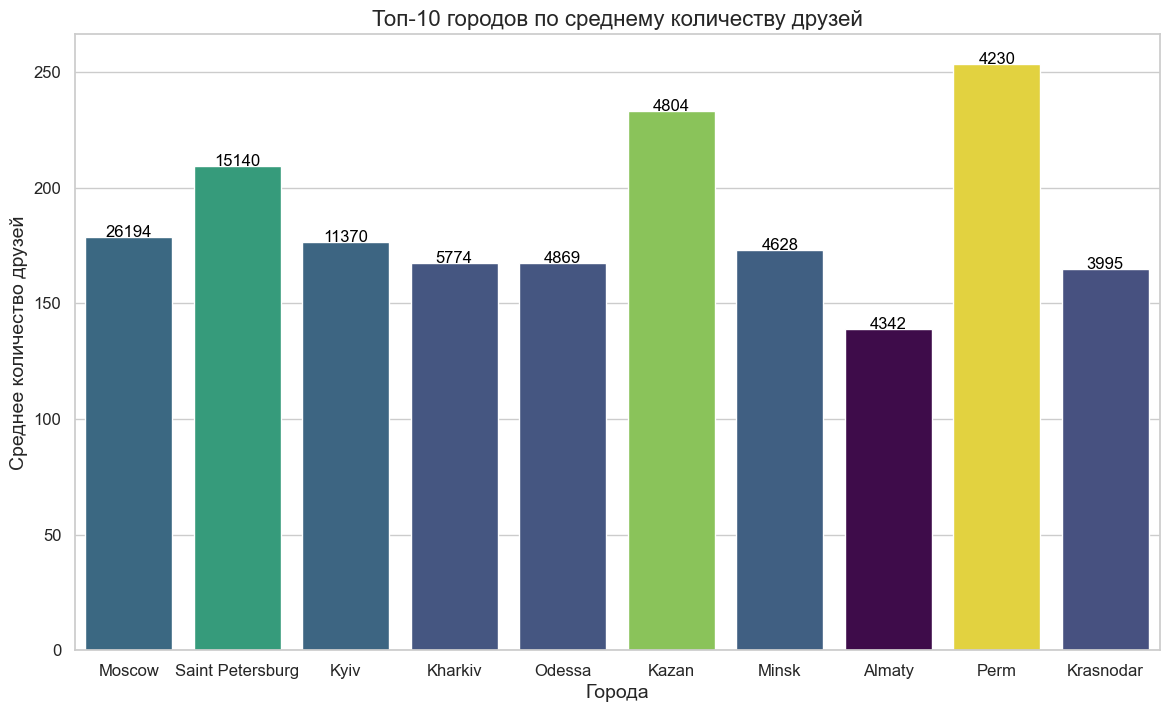

In [121]:
# подготовка данных для отрисовки графика
df_grouped = df_filtered_cities.groupby('CityName')['FriendsCount'].agg(['count', 'mean']).reset_index()
df_grouped_sorted = df_grouped.sort_values(by=['count', 'mean'], ascending=False).head(10)

# построение графика
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='CityName', y='mean', hue='mean', data=df_grouped_sorted, palette='viridis')
# добавление подписей количества участников в каждом городе над столбцами
for index, row in df_grouped_sorted.iterrows():
    barplot.text(row['CityName'], row['mean'], int(row['count']), color='black', ha="center", fontsize=12)

barplot.legend_.remove()

plt.xlabel('Города', fontsize=14)
plt.ylabel('Среднее количество друзей', fontsize=14)
plt.title('Топ-10 городов по среднему количеству друзей', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

Таким образом среди городов для которых количество участников группы более 10-ти тысяч, по среднему количеству друзей лидирует Санкт-Петербург со значением 209 друзей. На втором месте Москва и 178 друзей, а на третьем с небольшим отрывом Киев и 176 друзей. Среди городов с количестом участников до 10 тысяч(примерно от 4-х до 6-ти тысяч), тройка лидеров выглядит вот так: Пермь - 253 друга, Казань - 233 друга и Минск - 173 друга.

**Какой город самый часто встречаемый у участников этой группы**

In [99]:
# получаем топ-10
df['CityName'].value_counts().head(10)

CityName
                    263799
Moscow               41431
Saint Petersburg     24007
Kyiv                 12487
Kazan                 7047
Kharkiv               6424
Perm                  6416
Minsk                 6328
Krasnodar             6086
Samara                6051
Name: count, dtype: int64

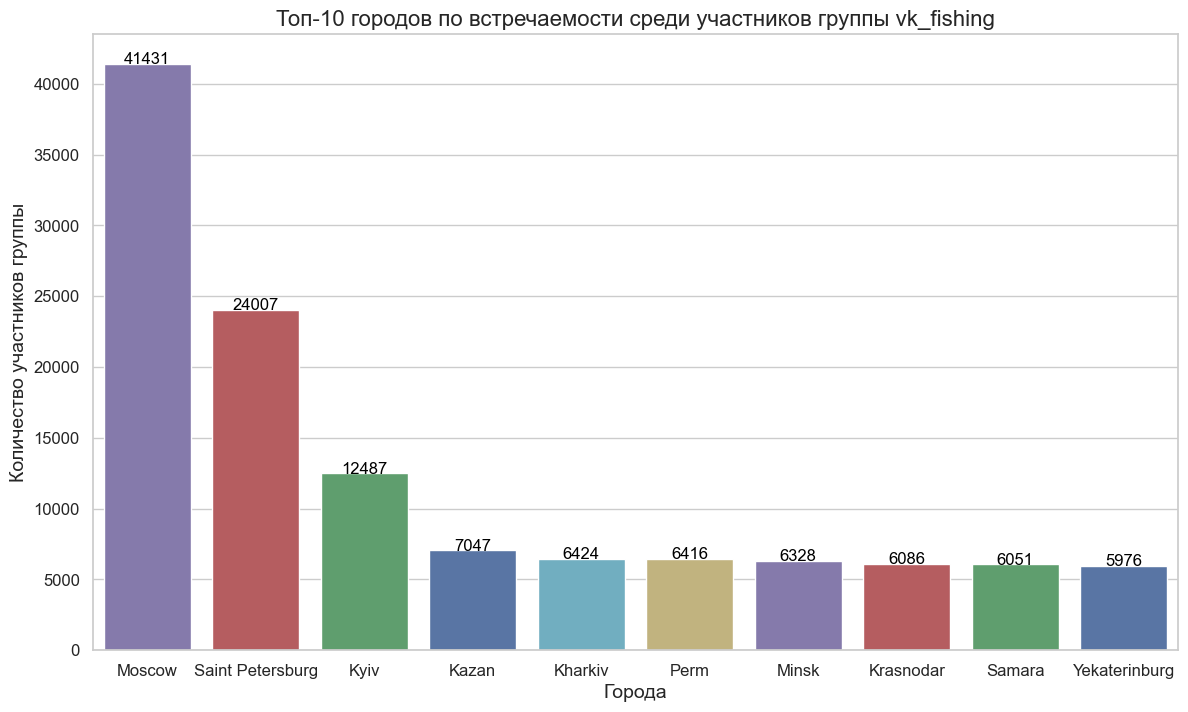

In [122]:
# подготовка данных для графика
df_grouped_sorted = df[df['CityName'] != '']['CityName'].value_counts().reset_index().head(10)

# построение графика
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='CityName', y='count', hue='count', data=df_grouped_sorted, palette='deep6')
# подпись количества участников над столбцами 
for index, row in df_grouped_sorted.iterrows():
    barplot.text(row['CityName'], row['count'], int(row['count']), color='black', ha="center", fontsize=12)

barplot.legend_.remove()
plt.xlabel('Города', fontsize=14)
plt.ylabel('Количество участников группы', fontsize=14)
plt.title('Топ-10 городов по встречаемости среди участников группы vk_fishing', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.show()

После очистки данных от значений в которых город был не заполнен или заполнен но некорректно, лидером среди городов по числу участников этой группы, является Москва со значением в 41 431 участника.

In [123]:
df.head()

,UserID,FirstName,LastName,LastSeenTime,Contacts,CityName,FriendsCount
0,48,Misha,Melnikov,1970-01-01 00:00:00,nan,,0
1,1018,Yarik,Burim,2021-02-19 04:15:36,nan,Saint Petersburg,0
2,1185,Alexey,Mogilov,1970-01-01 00:00:00,nan,,189
3,1721,Maxim,Lotsoka,1970-01-01 00:00:00,nan,,748
4,2136,Yaroslav,Tekhnik,2022-09-29 19:13:26,nan,Ryazan,70


In [129]:
len(df[df['Contacts'] == 'nan'])

794970

**Вывод**  
После выгрузки данных с сайта мы получили датафрейм с 858 367 записями в нем. Дубликатов в этих данных нет. Почти во всех данных наблюдаются пропущенные значения, это связано с обработкой некорректного ввода на этапе загрузки данных. В данных о количестве друзей наблюдаются существенные выбросы как в большую, так и в меньшую сторону. Подавляющее большинство данных(794 970 записей) не содержит контактных сведений, так как они не были размещены этими пользователями на сайте. 
Нами были проведены все запрошенные исследования, а именно: 
1) Топ-5 самых популярных имен: Александр, Сергей, Андрей, Алексей, Дмитрий.
2) Построена диаграмма зависимости количества друзей от возраста.
3) Топ-3 города с наибольшим средним значением количества друзей участников группы: 
    - Для городов с числом участников группы от 10 тысяч и выше: Санкт-Петрбург, Москва, Киев.
    - Для городов с числом участников группы от 4-х до 6-ти тысяч: Пермь, Казань, Минск.
4) Самый часто встречаемый город у участников этой группы - Москва.  
  
Для дальнейшей работы с данными и более углубленного изучения, рекомендуется очистка от выбросов и неактуальных значений. На текущий момент эта процедура не проведена, так как нет понимания, какая часть данных для нас наиболее ценна и какие данные бизнес-заказчик хочет получить из этих данных.  